In [1]:
import pandas as pd

credits = pd.read_csv('./tmdb_5000_credits.csv')
movies = pd.read_csv('./tmdb_5000_movies.csv')

View data set information

In [3]:
movies.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800


In [4]:
credits.head(1)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


json data processing

In [5]:
import json
json_col = ['cast','crew']
for i in json_col:
    credits[i] = credits[i].apply(json.loads)

credits['cast'][0][:3]

[{'cast_id': 242,
  'character': 'Jake Sully',
  'credit_id': '5602a8a7c3a3685532001c9a',
  'gender': 2,
  'id': 65731,
  'name': 'Sam Worthington',
  'order': 0},
 {'cast_id': 3,
  'character': 'Neytiri',
  'credit_id': '52fe48009251416c750ac9cb',
  'gender': 1,
  'id': 8691,
  'name': 'Zoe Saldana',
  'order': 1},
 {'cast_id': 25,
  'character': 'Dr. Grace Augustine',
  'credit_id': '52fe48009251416c750aca39',
  'gender': 1,
  'id': 10205,
  'name': 'Sigourney Weaver',
  'order': 2}]

Create a get_names() function to further split the cast

In [6]:
def get_names(x):
   return ','.join(i['name'] for i in x)
credits['cast'] = credits['cast'].apply(get_names)
credits['cast'][:3]

0    Sam Worthington,Zoe Saldana,Sigourney Weaver,S...
1    Johnny Depp,Orlando Bloom,Keira Knightley,Stel...
2    Daniel Craig,Christoph Waltz,Léa Seydoux,Ralph...
Name: cast, dtype: object

In [7]:
print(credits[['crew']][:3])
credits.rename(columns = {'crew':'director'},inplace=True)
credits[['director']][:3]

                                                crew
0  [{'credit_id': '52fe48009251416c750aca23', 'de...
1  [{'credit_id': '52fe4232c3a36847f800b579', 'de...
2  [{'credit_id': '54805967c3a36829b5002c41', 'de...


,director
0,"[{'credit_id': '52fe48009251416c750aca23', 'de..."
1,"[{'credit_id': '52fe4232c3a36847f800b579', 'de..."
2,"[{'credit_id': '54805967c3a36829b5002c41', 'de..."


genres, keywords, spoken_languages, production_countries, producion_companies require json parsing

In [8]:
json_col = ['genres','keywords','spoken_languages','production_countries','production_companies']
for i in json_col:
    movies[i] = movies[i].apply(json.loads)
    movies[i] = movies[i].apply(get_names)

After processing the data, start the analysis

In [9]:
df = credits.merge(right=movies,how='inner',left_on='movie_id',right_on='id')

Field missing value processing

In [10]:
del df['title_y']
del df['id']

In [11]:
df['release_date']=df['release_date'].fillna('2014-06-01')
df['runtime']=df['runtime'].fillna(df['runtime'].mean())

In [12]:
df[['release_date','runtime']].isnull().describe()

,release_date,runtime
count,4803,4803
unique,1,1
top,False,False
freq,4803,4803


Data analysis and visualization

In [13]:
df['release_year'] = pd.to_datetime(df.release_date,format='%Y-%m-%d').dt.year
df['release_month'] = pd.to_datetime(df.release_date,format='%Y-%m-%d').dt.month

In [14]:
df['genres'][1].split(',')

['Adventure', 'Fantasy', 'Action']

In [15]:
genre = set()
for i in df['genres'].str.split(','):
    genre=set().union(i,genre)
genre

{'',
 'Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Foreign',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'TV Movie',
 'Thriller',
 'War',
 'Western'}

In [16]:
genre = list(genre)
genre.remove('')

Movie type and number

In [17]:
for i in genre:
    df[i] = 0
    df[i][df.genres.str.contains(i)]  = 1

<ipython-input-17-a8aa6911307c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i][df.genres.str.contains(i)]  = 1


Create a dataframe containing movie genre and year

In [19]:
df_gy = df[genre+['release_year']]

Visualizing annual film trends

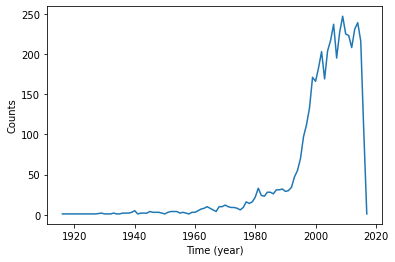

In [20]:
import matplotlib.pyplot as plt
x = df_gy['release_year'].value_counts().sort_index()
plt.plot(x)
plt.xlabel('Time (year)')
plt.ylabel('Counts')
plt.show()

Draw sub-type movies-time chart

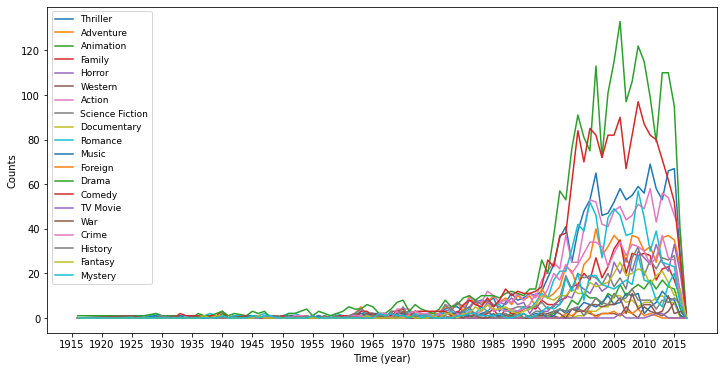

In [22]:
x = df_gy.groupby('release_year').sum()
plt.figure(figsize=(12,6))
plt.xticks(range(1915,2018,5))
plt.plot(x)
plt.legend(x.columns.values,fontsize = 9)
plt.xlabel('Time (year)')
plt.ylabel('Counts')
plt.show()

Draw a histogram of total movies

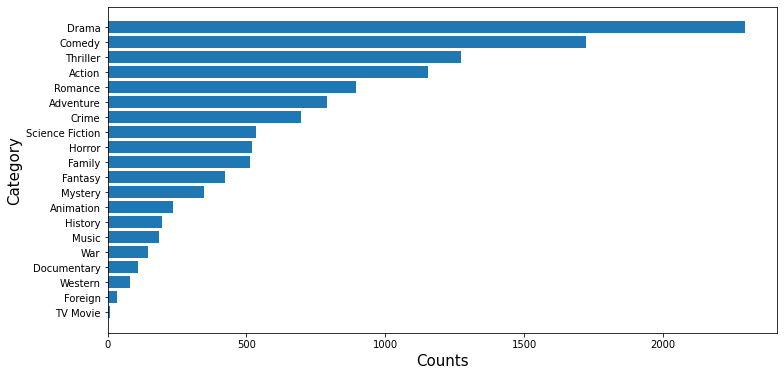

In [23]:
y = x.sum().sort_values()
plt.figure(figsize=(12,6))
plt.xlabel('Counts',fontsize = 15)
plt.ylabel('Category',fontsize = 15)
plt.barh(y.index,y)
plt.show()

<ipython-input-24-7587a0338dd5>:3: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  plt.pie(bl,labels=bl.index,autopct='%1.1f%%',explode=(bl>=0.06)/20+0.02)


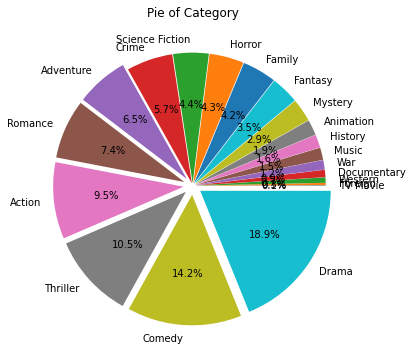

In [24]:
bl = y / y.sum()
plt.figure(figsize=(6,6))
plt.pie(bl,labels=bl.index,autopct='%1.1f%%',explode=(bl>=0.06)/20+0.02)
plt.title('Pie of Category')
plt.show()

In [25]:
df_revenue = df.groupby('release_year')['revenue'].sum()
df_revenue[:5]

release_year
1916     8394751
1925    22000000
1927      650422
1929     4358000
1930     8000000
Name: revenue, dtype: int64

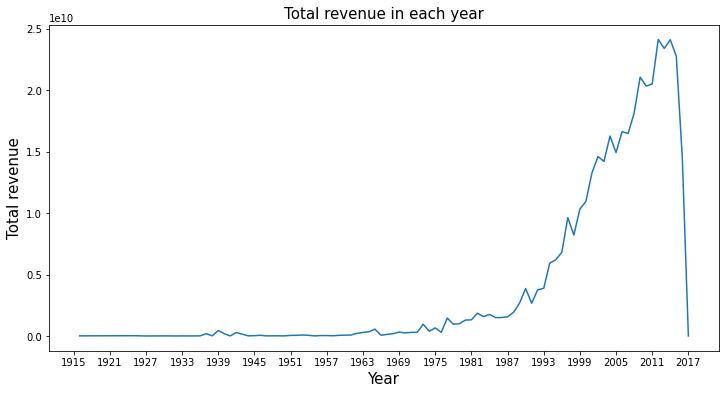

In [26]:
df_revenue.plot(figsize=(12,6))
plt.xticks(range(1915,2018,6))
plt.title('Total revenue in each year',fontsize = 15)
plt.xlabel('Year',fontsize = 15)
plt.ylabel('Total revenue',fontsize = 15)
plt.show()

The relationship between movie budget and box office

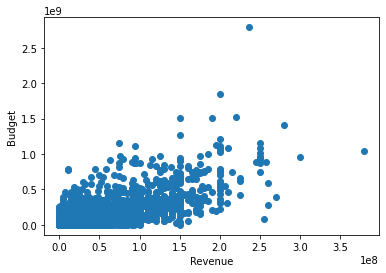

In [27]:
plt.scatter(x=df.budget,y = df.revenue)
plt.xlabel('Revenue')
plt.ylabel('Budget')
plt.show()

The relationship between ratings and box office

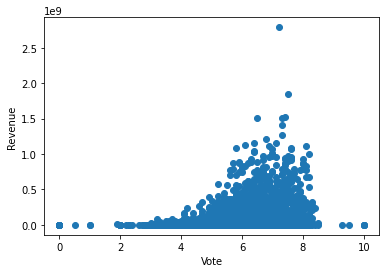

In [28]:
plt.scatter(x = df.vote_average,y = df.revenue)
plt.xlabel('Vote')
plt.ylabel('Revenue')
plt.show()